# ResNet34d Testing for CV

- ResNet50 as backbone
- LoRA to optimize fine tuning layers

## 1. Installation

In [1]:
# Install necessary packages
# !pip install -q torch torchvision timm pycocotools albumentations peft

# Import libraries
import os
import json
import numpy as np
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm

# Set up paths
image_folder_path = '/home/jupyter/advanced/cv/'
path2data = os.path.join(image_folder_path, 'images')
path2json = os.path.join(image_folder_path, 'annotations.json')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 2. Load, Check Data

In [2]:
# Load annotations
with open(path2json, 'r') as f:
    coco_data = json.load(f)

# Extract information
images = coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

print(f"Total images: {len(images)}")
print(f"Total annotations: {len(annotations)}")
print(f"Total categories: {len(categories)}")

Total images: 20000
Total annotations: 72967
Total categories: 18


Category ID: 0, Name: cargo aircraft
Category ID: 1, Name: commercial aircraft
Category ID: 2, Name: drone
Category ID: 3, Name: fighter jet
Category ID: 4, Name: fighter plane
Category ID: 5, Name: helicopter
Category ID: 6, Name: light aircraft
Category ID: 7, Name: missile
Category ID: 8, Name: truck
Category ID: 9, Name: car
Category ID: 10, Name: tank
Category ID: 11, Name: bus
Category ID: 12, Name: van
Category ID: 13, Name: cargo ship
Category ID: 14, Name: yacht
Category ID: 15, Name: cruise ship
Category ID: 16, Name: warship
Category ID: 17, Name: sailboat


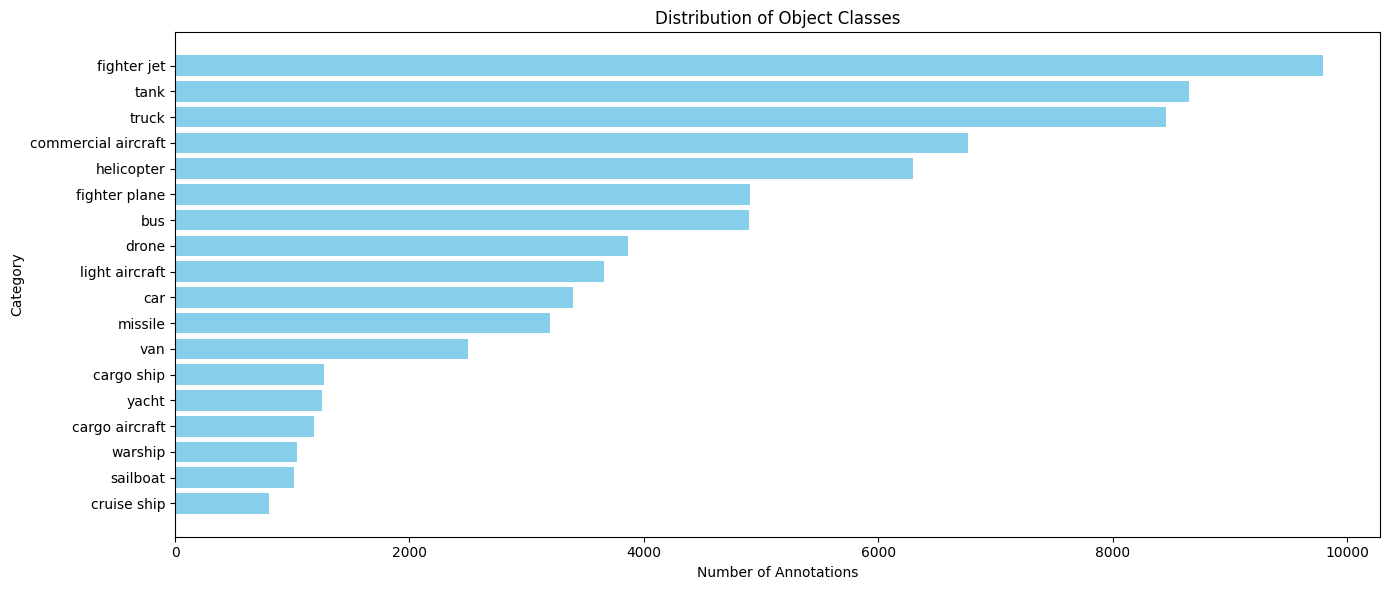

In [3]:
# Print category names
category_map = {cat['id']: cat['name'] for cat in categories}
for cat_id, cat_name in category_map.items():
    print(f"Category ID: {cat_id}, Name: {cat_name}")

# Check class distribution
category_counts = {}
for ann in annotations:
    cat_id = ann['category_id']
    if cat_id not in category_counts:
        category_counts[cat_id] = 0
    category_counts[cat_id] += 1

# Plot class distribution
plt.figure(figsize=(14, 6))
cat_ids = list(category_counts.keys())
cat_names = [category_map[cat_id] for cat_id in cat_ids]
cat_counts = [category_counts[cat_id] for cat_id in cat_ids]

# Sort by count for better visualization
sorted_indices = np.argsort(cat_counts)
cat_names = [cat_names[i] for i in sorted_indices]
cat_counts = [cat_counts[i] for i in sorted_indices]

plt.barh(cat_names, cat_counts, color='skyblue')
plt.xlabel('Number of Annotations')
plt.ylabel('Category')
plt.title('Distribution of Object Classes')
plt.tight_layout()
plt.show()

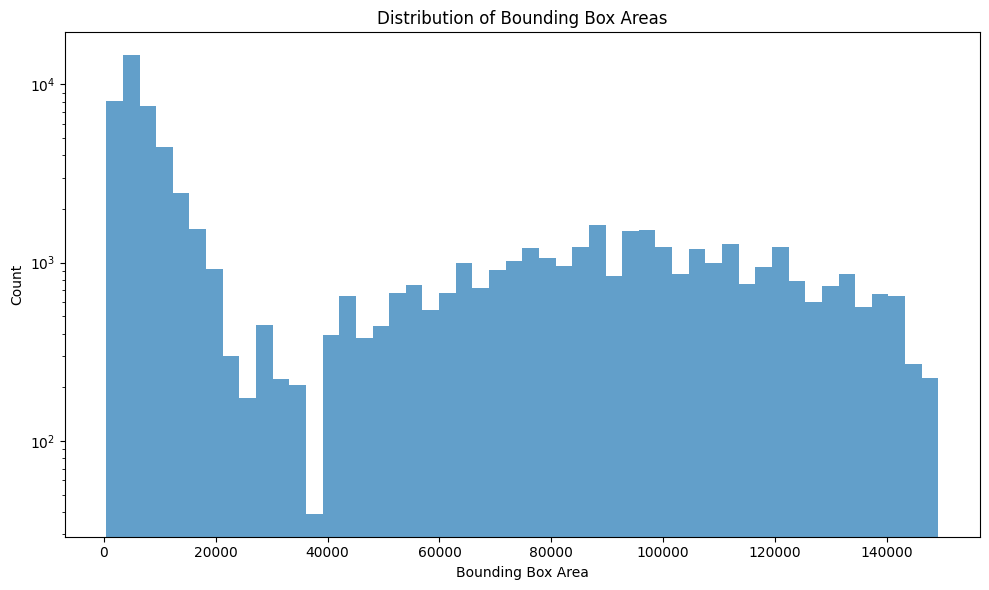

In [4]:
# Check box size distribution
areas = [ann['area'] for ann in annotations]
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=50, alpha=0.7)
plt.xlabel('Bounding Box Area')
plt.ylabel('Count')
plt.title('Distribution of Bounding Box Areas')
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.show()

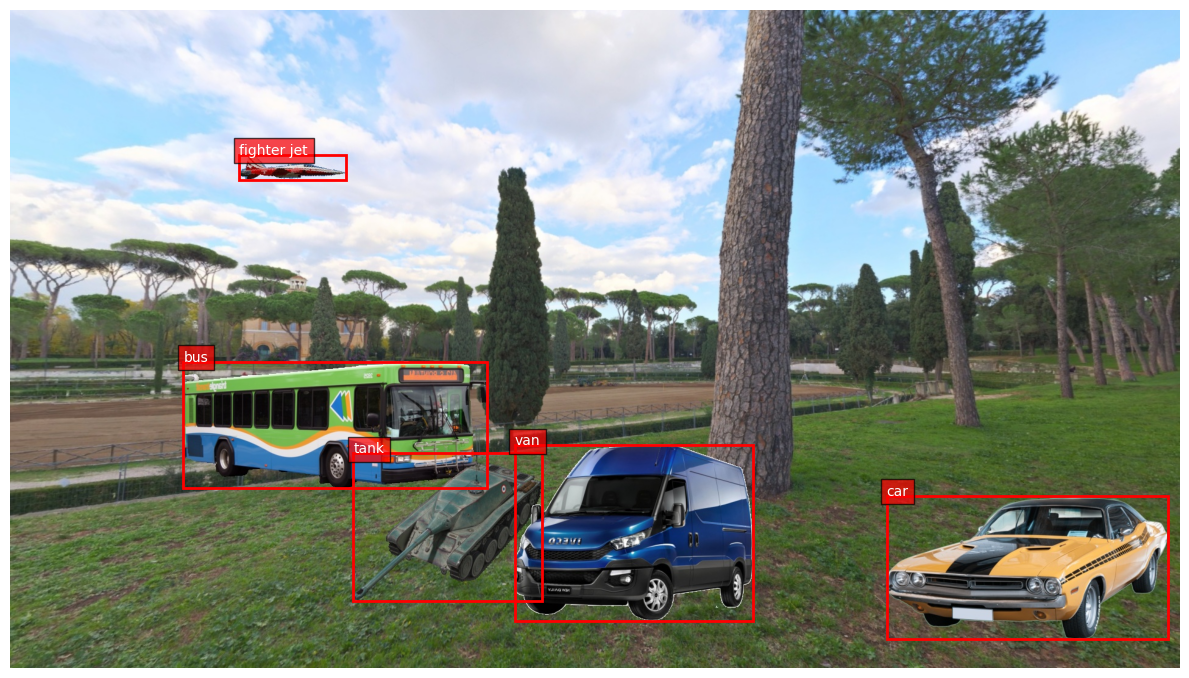

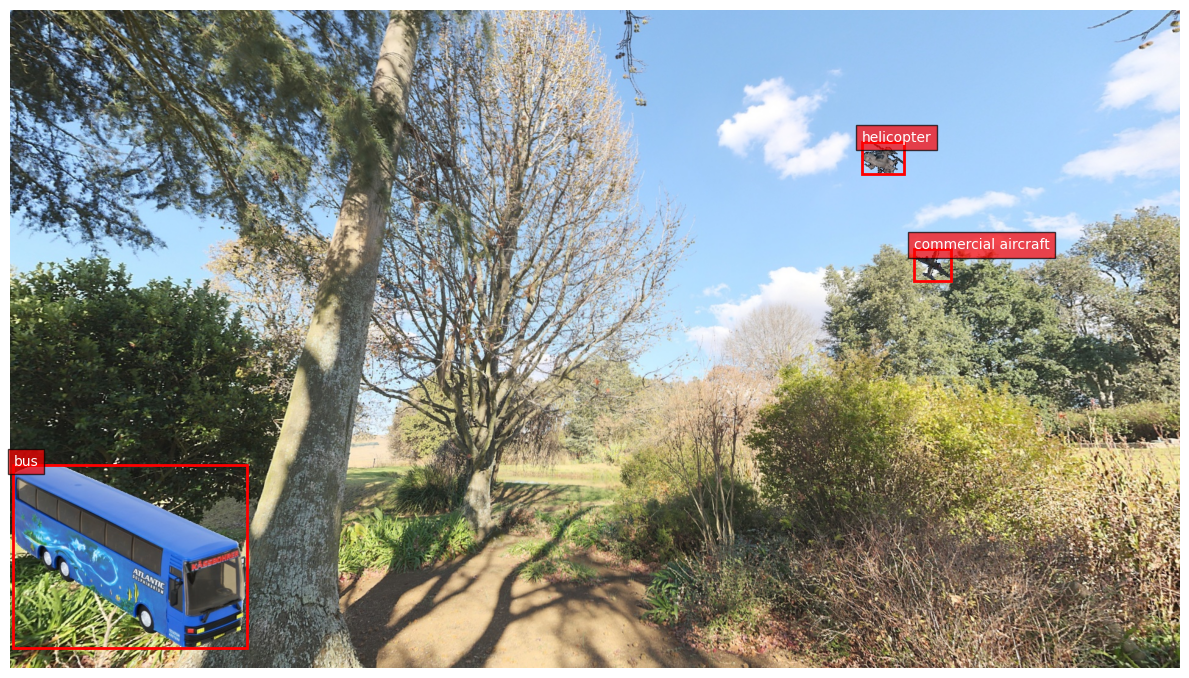

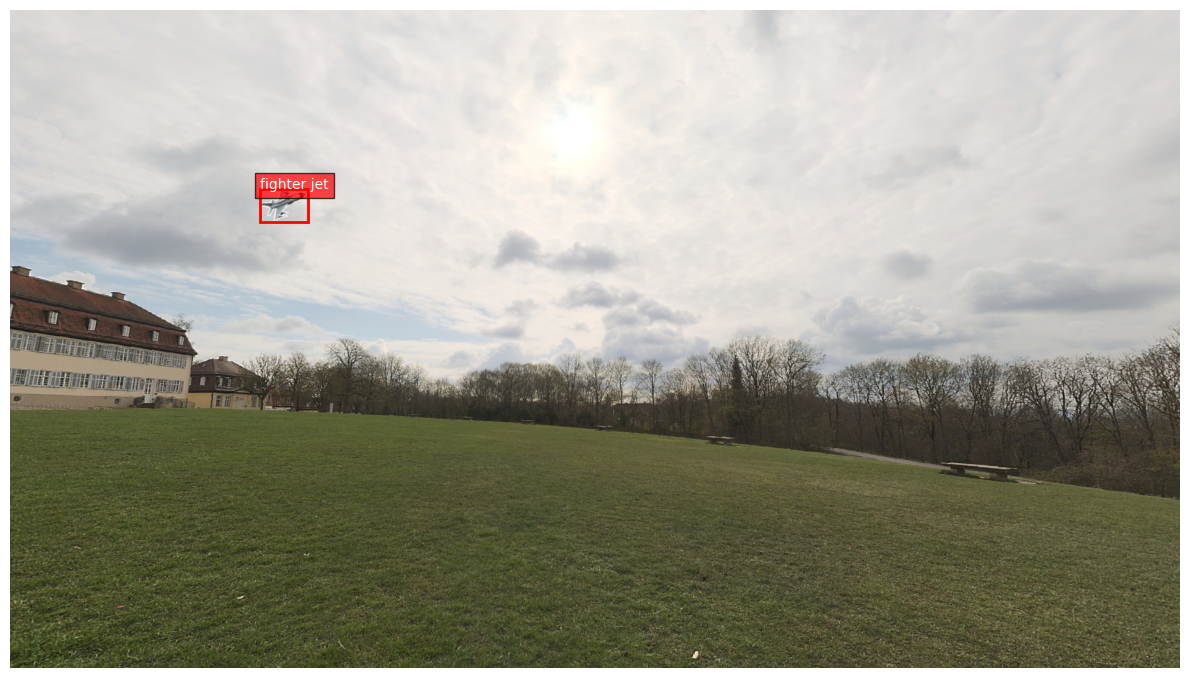

In [5]:
# Visualize some examples
def visualize_sample(image_id, show_boxes=True):
    # Find image info
    img_info = next((img for img in images if img['id'] == image_id), None)
    if not img_info:
        print(f"Image ID {image_id} not found.")
        return
    
    # Load image
    img_path = os.path.join(path2data, img_info['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    if show_boxes:
        # Get annotations for this image
        img_anns = [ann for ann in annotations if ann['image_id'] == image_id]
        
        # Draw each box
        for ann in img_anns:
            x, y, w, h = ann['bbox']
            category = category_map[ann['category_id']]
            
            # Create rectangle patch
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # Add label
            plt.text(x, y, category, color='white', fontsize=10,
                     bbox=dict(facecolor='red', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a few random samples
import random
random_image_ids = random.sample([img['id'] for img in images], 3)
for img_id in random_image_ids:
    visualize_sample(img_id)

## 3. Preprocess Data 

In [6]:
# Define COCO dataset class
class CocoDetectionDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform
        self.cat_mapping = {cat: idx for idx, cat in enumerate(self.coco.getCatIds())}
        self.idx_to_cat = {idx: cat for cat, idx in self.cat_mapping.items()}
    
    def __getitem__(self, index):
        # Get image ID
        img_id = self.ids[index]
        
        # Get image info and load image
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['filename'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Prepare boxes and labels
        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            # Convert to x1, y1, x2, y2 format
            x1, y1, x2, y2 = x, y, x + w, y + h
            boxes.append([x1, y1, x2, y2])
            # Map category_id to consecutive integers starting from 0
            labels.append(self.cat_mapping[ann['category_id']])
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        # Create target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        
        # Apply transformations
        if self.transform:
            if len(boxes) > 0:
                # Apply albumentations transforms
                transformed = self.transform(
                    image=img, 
                    bboxes=boxes.numpy().tolist(), 
                    labels=labels.numpy().tolist()
                )
                img = transformed['image']
                if len(transformed['bboxes']) > 0:
                    target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
                    target['labels'] = torch.as_tensor(transformed['labels'], dtype=torch.int64)
                else:
                    # If all boxes were removed during augmentation, return a dummy box
                    target['boxes'] = torch.zeros((1, 4), dtype=torch.float32)
                    target['labels'] = torch.zeros(1, dtype=torch.int64)
            else:
                # No boxes, just transform the image
                transformed = self.transform(image=img)
                img = transformed['image']
        else:
            # Convert to tensor manually if no transform
            img = torch.from_numpy(img.transpose((2, 0, 1))).float() / 255.0
        
        return img, target
    
    def __len__(self):
        return len(self.ids)

# Define transforms
def get_transform(train):
    if train:
        transform = A.Compose([
            A.OneOf([
                A.RandomSizedBBoxSafeCrop(height=800, width=800, p=0.5),
                A.Resize(height=800, width=800, p=0.5),
            ], p=1.0),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        transform = A.Compose([
            A.Resize(height=800, width=800),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    
    return transform

# Split dataset into train and validation
def get_data_loaders(path2data, path2json, batch_size=2):
    # Load COCO annotations
    with open(path2json, 'r') as f:
        coco_data = json.load(f)
    
    # Create a train/val split (assuming no predefined split)
    images = coco_data['images']
    np.random.shuffle(images)
    split_idx = int(len(images) * 0.8)  # 80% train, 20% val
    
    train_img_ids = [img['id'] for img in images[:split_idx]]
    val_img_ids = [img['id'] for img in images[split_idx:]]
    
    # Create new annotation files for train and val
    train_coco = {
        'images': [img for img in coco_data['images'] if img['id'] in train_img_ids],
        'annotations': [ann for ann in coco_data['annotations'] if ann['image_id'] in train_img_ids],
        'categories': coco_data['categories']
    }
    
    val_coco = {
        'images': [img for img in coco_data['images'] if img['id'] in val_img_ids],
        'annotations': [ann for ann in coco_data['annotations'] if ann['image_id'] in val_img_ids],
        'categories': coco_data['categories']
    }
    
    # Write the split annotations to disk
    train_json_path = path2json.replace('.json', '_train.json')
    val_json_path = path2json.replace('.json', '_val.json')
    
    with open(train_json_path, 'w') as f:
        json.dump(train_coco, f)
    
    with open(val_json_path, 'w') as f:
        json.dump(val_coco, f)
    
    print(f"Train images: {len(train_coco['images'])}")
    print(f"Train annotations: {len(train_coco['annotations'])}")
    print(f"Validation images: {len(val_coco['images'])}")
    print(f"Validation annotations: {len(val_coco['annotations'])}")
    
    # Create datasets
    train_dataset = CocoDetectionDataset(
        root=path2data,
        annFile=train_json_path,
        transform=get_transform(train=True)
    )
    
    val_dataset = CocoDetectionDataset(
        root=path2data,
        annFile=val_json_path,
        transform=get_transform(train=False)
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))  # Custom collate to handle variable size
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )
    
    num_classes = len(coco_data['categories'])
    
    return train_loader, val_loader, num_classes

# Create data loaders
train_loader, val_loader, num_classes = get_data_loaders(path2data, path2json, batch_size=2)
print(f"Number of classes: {num_classes}")

OSError: [Errno 30] Read-only file system: '/home/jupyter/advanced/cv/annotations_train.json'